In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Klasyfikacja

In [2]:
df = pd.read_csv('kredyt.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            534 non-null    object 
 1   Gender             521 non-null    object 
 2   Married            531 non-null    object 
 3   Dependents         519 non-null    object 
 4   Education          534 non-null    object 
 5   Self_Employed      502 non-null    object 
 6   ApplicantIncome    534 non-null    int64  
 7   CoapplicantIncome  534 non-null    float64
 8   LoanAmount         512 non-null    float64
 9   Loan_Amount_Term   520 non-null    float64
 10  Credit_History     484 non-null    float64
 11  Property_Area      534 non-null    object 
 12  Loan_Status        534 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 54.4+ KB


In [3]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
df = df.drop('Loan_ID', axis=1)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Uzupełnianie brakujących wartości 'Married' na podstawie informacji o zarobkach koaplikanta.

Ponieważ danych brakujących jest niewiele przyjmiemy, że osoby są po ślubie jeśli ich koaplikant ma niezerowe zarobki.

In [5]:
Married_braki = df[df['Married'].isna()]
Married_braki

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
90,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
193,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
375,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [6]:
dane = [{'Married': 'Yes'}, {'Married': 'No'}, {'Married': 'No'}]
predykcja = pd.DataFrame(dane, index = Married_braki['Married'].index, columns=['Married'])
predykcja

,Married
90,Yes
193,No
375,No


In [7]:
df['Married'] = pd.concat([predykcja, df['Married'].dropna(how = 'any')])
df.loc[predykcja.index]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
90,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
193,Male,No,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
375,Female,No,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [8]:
df.isna().sum()

Gender               13
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Uzupełnianie brakujących wartości 'Dependents' modą w grupach.

In [9]:
moda = df[['Dependents', 'Property_Area']].groupby('Property_Area').value_counts()
wynik_moda = moda.groupby('Property_Area').head(1).reset_index()
wynik_moda

,Property_Area,Dependents,count
0,Rural,0,98
1,Semiurban,0,112
2,Urban,0,93


In [10]:
uzupelnienie_moda = pd.merge(df, wynik_moda, right_on='Property_Area',left_on='Property_Area', how='left')['Dependents_y']
uzupelnienie_moda

0      0
1      0
2      0
3      0
4      0
      ..
529    0
530    0
531    0
532    0
533    0
Name: Dependents_y, Length: 534, dtype: object

In [11]:
df['Dependents'] = df['Dependents'].fillna(uzupelnienie_moda)
df.isna().sum()

Gender               13
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Uzupełnianie brakujących wartości 'Loan_Amount_Term' modą w grupach.

In [12]:
df[df['Loan_Amount_Term'].isna()].head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
18,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
33,Male,Yes,0,Graduate,No,1828,1330.0,100.0,NaN,0.0,Urban,N
39,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,Y
40,Female,No,0,Graduate,No,3410,0.0,88.0,NaN,1.0,Urban,Y
64,Male,Yes,3+,Not Graduate,No,4755,0.0,95.0,NaN,0.0,Semiurban,N


In [13]:
moda = df[['Loan_Amount_Term', 'Property_Area']].groupby('Property_Area').value_counts()
wynik_moda = moda.groupby('Property_Area').head(1).reset_index()
wynik_moda

,Property_Area,Loan_Amount_Term,count
0,Rural,360.0,139
1,Semiurban,360.0,172
2,Urban,360.0,133


In [14]:
uzupelnienie_moda = pd.merge(df, wynik_moda, right_on='Property_Area',left_on='Property_Area', how='left')['Loan_Amount_Term_y']
uzupelnienie_moda

0      360.0
1      360.0
2      360.0
3      360.0
4      360.0
       ...  
529    360.0
530    360.0
531    360.0
532    360.0
533    360.0
Name: Loan_Amount_Term_y, Length: 534, dtype: float64

In [15]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(uzupelnienie_moda)
df.isna().sum()

Gender               13
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Uzupełnianie brakujących wartości 'LoanAmount' średnią w grupach.

In [16]:
srednia = df[['LoanAmount', 'Property_Area']].groupby('Property_Area').mean()
wynik_srednia = srednia.round(0)
wynik_srednia

,LoanAmount
Property_Area,
Rural,152.0
Semiurban,146.0
Urban,144.0


In [17]:
uzupelnienie_srednia = pd.merge(df, srednia, right_on='Property_Area',left_on='Property_Area', how='left')['LoanAmount_y']
uzupelnienie_srednia

0      143.901235
1      152.083871
2      143.901235
3      143.901235
4      143.901235
          ...    
529    152.083871
530    152.083871
531    152.083871
532    143.901235
533    146.312821
Name: LoanAmount_y, Length: 534, dtype: float64

In [18]:
df['LoanAmount'] = df['LoanAmount'].fillna(uzupelnienie_srednia)
df.isna().sum()

Gender               13
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Klasyfikacja metodą drzew decyzyjnych brakujących wartości 'Gender'.

In [19]:
Gender = df[df['Gender'].isna()]
Gender

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
21,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
108,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
145,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
158,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,Y
269,NaN,Yes,0,Graduate,No,2473,1843.0,159.0,360.0,1.0,Rural,N
285,NaN,Yes,1,Graduate,Yes,9833,1833.0,182.0,180.0,1.0,Urban,Y
399,NaN,Yes,0,Graduate,Yes,2083,4083.0,160.0,360.0,NaN,Semiurban,Y
405,NaN,Yes,0,Graduate,No,16692,0.0,110.0,360.0,1.0,Semiurban,Y
415,NaN,Yes,2,Graduate,No,2873,1872.0,132.0,360.0,0.0,Semiurban,N
438,NaN,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N


In [20]:
dane = pd.get_dummies(df.dropna(how = 'any').drop(['Gender', 'Credit_History'], axis=1))
target = (df.dropna(how = 'any')['Gender'] == 'Male').astype(np.uint8)
target
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dane, target, test_size=0.3, random_state=14)
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
163,4191,0.0,120.0,360.0,True,False,True,False,False,False,True,False,True,False,True,False,False,False,True
505,1836,33837.0,90.0,360.0,True,False,True,False,False,False,True,False,True,False,False,False,True,True,False
252,6875,0.0,200.0,360.0,False,True,False,True,False,False,True,False,True,False,False,True,False,False,True
240,1811,1666.0,54.0,360.0,True,False,True,False,False,False,True,False,True,False,False,False,True,False,True
467,4608,2845.0,140.0,180.0,False,True,False,True,False,False,True,False,True,False,False,True,False,False,True


In [21]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(5,20)}
drzewo_decyzyjne = tree.DecisionTreeClassifier()
drzewo_gscv = GridSearchCV(drzewo_decyzyjne, param_grid, cv=5)
drzewo_gscv.fit(X_train, Y_train)
drzewo_gscv.best_params_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}

In [22]:
Gender_drzewo = tree.DecisionTreeClassifier(max_depth= drzewo_gscv.best_params_['max_depth'], min_samples_leaf=drzewo_gscv.best_params_['min_samples_leaf'])
Gender_drzewo.fit(X_train, Y_train)

print('train accuracy: ', Gender_drzewo.score(X_train, Y_train))
print('test accuracy: ', Gender_drzewo.score(X_test, Y_test))

train accuracy:  0.8397435897435898
test accuracy:  0.8059701492537313


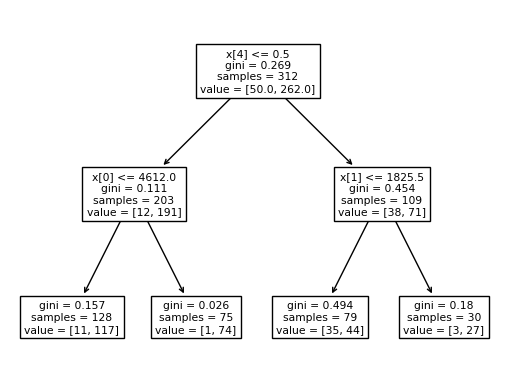

In [23]:
tree.plot_tree(Gender_drzewo)
plt.show()

#Lepszą wizualizację drzew daje poniższy kod przy działaniu wszystkich importowanych bibliotek na używanym urządzeniu:

#from IPython.display import Image
#import pydotplus
#import graphviz
#dot_data = tree.export_graphviz(Gender_drzewo, feature_names=dane.columns, out_file=None, 
#                                filled=True,impurity=False, node_ids=True)
#graph = pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())

In [24]:
dane_z_brakami = pd.get_dummies(Gender.drop(['Gender', 'Credit_History'], axis=1))
dane_z_brakami.isna().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Married_No                 0
Married_Yes                0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Graduate         0
Education_Not Graduate     0
Self_Employed_No           0
Self_Employed_Yes          0
Property_Area_Rural        0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status_N              0
Loan_Status_Y              0
dtype: int64

In [25]:
Gender_predykcja = pd.DataFrame(Gender_drzewo.predict(dane_z_brakami), index = Gender.index, columns=['Gender'])
Gender_predykcja = Gender_predykcja.replace({1: 'Male', 0: 'Female'})
Gender_predykcja

,Gender
21,Male
108,Male
145,Male
158,Male
269,Male
285,Male
399,Male
405,Male
415,Male
438,Male


In [26]:
predykcja = pd.DataFrame(Gender_predykcja, index = df[df['Gender'].isna()].index, columns=['Gender'])
df['Gender'] = pd.concat([predykcja, df['Gender'].dropna(how = 'any')])
df.isna().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Klasyfikacja metodą drzew decyzyjnych brakujących wartości 'Credit_History'.

In [27]:
Credit_history = df[df['Credit_History'].isna()]
Credit_history.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
15,Male,No,1,Not Graduate,No,3596,0.0,100.0,240.0,NaN,Urban,Y
22,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
27,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N
38,Male,Yes,0,Graduate,No,2400,0.0,75.0,360.0,NaN,Urban,Y
69,Male,Yes,3+,Not Graduate,Yes,3333,2166.0,130.0,360.0,NaN,Semiurban,Y


In [28]:
dane = pd.get_dummies(df.dropna(how = 'any').drop(['Self_Employed', 'Credit_History'], axis=1))
target = df.dropna(how = 'any')['Credit_History']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dane, target, test_size=0.3, random_state=14)
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
106,4300,2014.0,194.0,360.0,False,True,False,True,True,False,False,False,False,True,True,False,False,False,True
464,3617,0.0,107.0,360.0,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True
145,51763,0.0,700.0,300.0,False,True,False,True,False,False,False,True,True,False,False,False,True,False,True
518,6383,1000.0,187.0,360.0,False,True,False,True,False,False,True,False,False,True,True,False,False,True,False
508,4283,3000.0,172.0,84.0,False,True,False,True,False,True,False,False,True,False,True,False,False,True,False


In [29]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(5,20)}
drzewo_decyzyjne = tree.DecisionTreeClassifier()
drzewo_gscv = GridSearchCV(drzewo_decyzyjne, param_grid, cv=5)
drzewo_gscv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
                         'min_samples_leaf': range(5, 20)})

In [30]:
Credit_History_drzewo = tree.DecisionTreeClassifier(max_depth= drzewo_gscv.best_params_['max_depth'], min_samples_leaf=drzewo_gscv.best_params_['min_samples_leaf'])
Credit_History_drzewo.fit(dane,target)

print('train accuracy: ', Credit_History_drzewo.score(X_train, Y_train))
print('test accuracy: ', Credit_History_drzewo.score(X_test, Y_test))

train accuracy:  0.865625
test accuracy:  0.8695652173913043


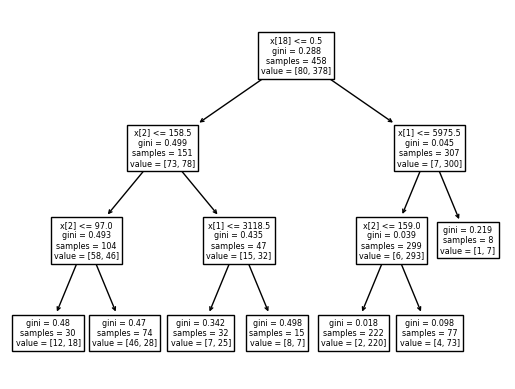

In [31]:
tree.plot_tree(Credit_History_drzewo)
plt.show()

#Lepszą wizualizację drzew daje poniższy kod przy działaniu wszystkich importowanych bibliotek na używanym urządzeniu:

#from IPython.display import Image
#import pydotplus
#import graphviz
#dot_data = tree.export_graphviz(Credit_History_drzewo, feature_names=dane.columns, out_file=None, 
#                                filled=True,impurity=False, node_ids=True)
#graph = pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())

In [32]:
dane_z_brakami = pd.get_dummies(Credit_history.drop(['Self_Employed', 'Credit_History'], axis=1))
dane_z_brakami.isna().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Gender_Female              0
Gender_Male                0
Married_No                 0
Married_Yes                0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Graduate         0
Education_Not Graduate     0
Property_Area_Rural        0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status_N              0
Loan_Status_Y              0
dtype: int64

In [33]:
Credit_History_predykcja = pd.DataFrame(Credit_History_drzewo.predict(dane_z_brakami), index = Credit_history.index, columns=['Credit_History'])
Credit_History_predykcja.head()

,Credit_History
15,1.0
22,0.0
27,0.0
38,1.0
69,1.0


In [34]:
predykcja = pd.DataFrame(Credit_History_predykcja, index = df[df['Credit_History'].isna()].index, columns=['Credit_History'])
df['Credit_History'] = pd.concat([predykcja, df['Credit_History'].dropna(how = 'any')])
df.isna().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

## Klasyfikacja metodą drzew decyzyjnych brakujących wartości 'Self_Employed'.

In [35]:
dane = pd.get_dummies(df.dropna(how = 'any').drop(['Self_Employed'], axis=1))
target = (df.dropna(how = 'any')['Self_Employed'] == 'Yes').astype(np.uint8)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dane, target, test_size=0.3, random_state=14)
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
119,5417,0.0,168.0,360.0,1.0,False,True,True,False,True,False,False,False,True,False,False,False,True,False,True
506,3166,0.0,36.0,360.0,1.0,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True
270,3399,1640.0,111.0,180.0,1.0,False,True,False,True,False,True,False,False,False,True,False,False,True,False,True
100,2214,1398.0,85.0,360.0,1.0,False,True,False,True,False,True,False,False,True,False,False,False,True,False,True
356,2149,3237.0,178.0,360.0,0.0,True,False,False,True,True,False,False,False,False,True,False,True,False,True,False


In [36]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(5,20)}
drzewo_decyzyjne = tree.DecisionTreeClassifier()
drzewo_gscv = GridSearchCV(drzewo_decyzyjne, param_grid, cv=5)
drzewo_gscv.fit(X_train, Y_train)
drzewo_gscv.best_params_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 16}

In [37]:
Self_Employed_drzewo = tree.DecisionTreeClassifier(max_depth= drzewo_gscv.best_params_['max_depth'], min_samples_leaf=drzewo_gscv.best_params_['min_samples_leaf'])
Self_Employed_drzewo.fit(X_train, Y_train)


print('train accuracy: ', Self_Employed_drzewo.score(X_train, Y_train))
print('test accuracy: ', Self_Employed_drzewo.score(X_test, Y_test))

train accuracy:  0.8632478632478633
test accuracy:  0.847682119205298


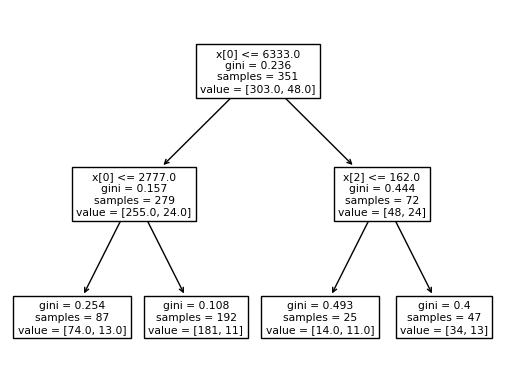

In [38]:
tree.plot_tree(Self_Employed_drzewo)
plt.show()

#Lepszą wizualizację drzew daje poniższy kod przy działaniu wszystkich importowanych bibliotek na używanym urządzeniu:

#from IPython.display import Image
#import pydotplus
#import graphviz
#dot_data = tree.export_graphviz(Self_Employed_drzewo, feature_names=dane.columns, out_file=None, 
#                                filled=True,impurity=False, node_ids=True)
#graph = pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())

In [39]:
dane_z_brakami = pd.get_dummies(df[df['Self_Employed'].isna()].drop(['Self_Employed'], axis=1))
dane_z_brakami.isna().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Gender_Female              0
Gender_Male                0
Married_No                 0
Married_Yes                0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Graduate         0
Education_Not Graduate     0
Property_Area_Rural        0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status_N              0
Loan_Status_Y              0
dtype: int64

In [40]:
Self_Employed_predykcja = pd.DataFrame(Self_Employed_drzewo.predict(dane_z_brakami), index = df[df['Self_Employed'].isna()]['Self_Employed'].index, columns=['Self_Employed'])
Self_Employed_predykcja = Self_Employed_predykcja.replace({1: 'Yes', 0: 'No'})
Self_Employed_predykcja

,Self_Employed
10,No
18,No
22,No
26,No
27,No
81,No
92,No
94,No
97,No
133,No


In [41]:
predykcja = pd.DataFrame(Self_Employed_predykcja, index = df[df['Self_Employed'].isna()]['Self_Employed'].index, columns=['Self_Employed'])
df['Self_Employed'] = pd.concat([predykcja, df['Self_Employed'].dropna(how = 'any')])
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Klasyfikacja wartości 'Loan_Status'

In [42]:
dane = pd.get_dummies(df.drop(['Loan_Status'], axis=1))
target = df['Loan_Status']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dane, target, test_size=0.3, random_state=14)
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
77,5695,4167.0,175.0,360.0,1.0,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False
456,5285,1430.0,161.0,360.0,0.0,False,True,False,True,False,True,False,False,False,True,True,False,False,True,False
170,4923,0.0,166.0,360.0,0.0,False,True,True,False,False,False,True,False,True,False,True,False,False,True,False
234,2620,2223.0,150.0,360.0,1.0,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False
179,5703,0.0,130.0,360.0,1.0,False,True,False,True,False,False,False,True,False,True,False,True,True,False,False


In [43]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': [2,3,4,5,6,7,8,None], 
              'min_samples_leaf': range(5,20)}
drzewo_decyzyjne = tree.DecisionTreeClassifier()
drzewo_gscv = GridSearchCV(drzewo_decyzyjne, param_grid, cv=5)
drzewo_gscv.fit(X_train, Y_train)
drzewo_gscv.best_params_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}

In [44]:
print('train accuracy: ', drzewo_gscv.score(X_train, Y_train))
print('test accuracy: ', drzewo_gscv.score(X_test, Y_test))

train accuracy:  0.8123324396782842
test accuracy:  0.84472049689441


In [45]:
Loan_Status_drzewo = tree.DecisionTreeClassifier(max_depth= drzewo_gscv.best_params_['max_depth'], min_samples_leaf=drzewo_gscv.best_params_['min_samples_leaf'])
Loan_Status_drzewo.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

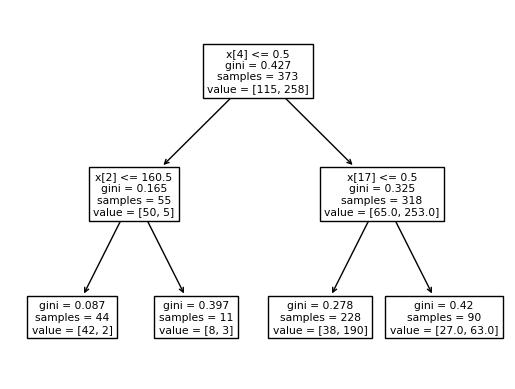

In [47]:
tree.plot_tree(Loan_Status_drzewo)
plt.show()

#Lepszą wizualizację drzew daje poniższy kod przy działaniu wszystkich importowanych bibliotek na używanym urządzeniu:

#from IPython.display import Image
#import pydotplus
#import graphviz
#dot_data = tree.export_graphviz(Loan_Status_drzewo, feature_names=dane.columns, out_file=None, 
#                                filled=True,impurity=False, node_ids=True)
#graph = pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())

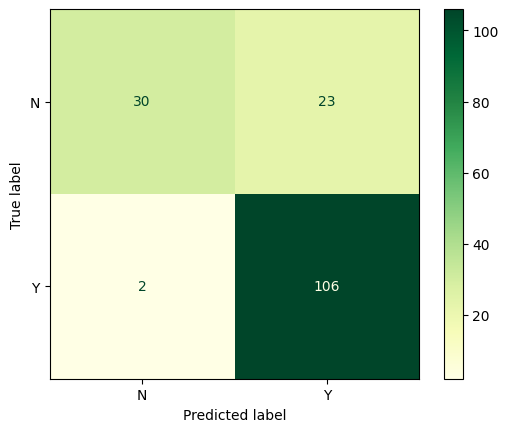

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(Loan_Status_drzewo, X_test, Y_test, cmap='YlGn')
plt.show()

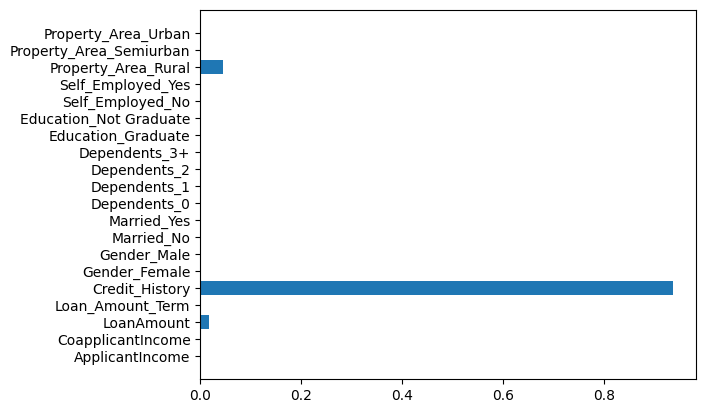

In [49]:
feature_importances = Loan_Status_drzewo.feature_importances_
plt.barh(X_test.columns, feature_importances)
plt.show()

## Klasyfikacja przyznania kredytu na podstawie danych z pliku kredyt_test.csv rozważanym powyżej modelem.

In [50]:
dane_testowe = pd.read_csv('kredyt_test.csv')
dane_testowe.info()
dane_testowe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            80 non-null     object 
 1   Gender             80 non-null     object 
 2   Married            80 non-null     object 
 3   Dependents         80 non-null     object 
 4   Education          80 non-null     object 
 5   Self_Employed      80 non-null     object 
 6   ApplicantIncome    80 non-null     int64  
 7   CoapplicantIncome  80 non-null     float64
 8   LoanAmount         80 non-null     float64
 9   Loan_Amount_Term   80 non-null     float64
 10  Credit_History     80 non-null     float64
 11  Property_Area      80 non-null     object 
dtypes: float64(4), int64(1), object(7)
memory usage: 7.6+ KB


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001819,Male,Yes,1,Not Graduate,No,6608,0.0,137.0,180.0,1.0,Urban
1,LP002065,Male,Yes,3+,Graduate,No,15000,0.0,300.0,360.0,1.0,Rural
2,LP001430,Female,No,0,Graduate,No,4166,0.0,44.0,360.0,1.0,Semiurban
3,LP002459,Male,Yes,0,Graduate,No,4301,0.0,118.0,360.0,1.0,Urban
4,LP001594,Male,Yes,0,Graduate,No,5708,5625.0,187.0,360.0,1.0,Semiurban


W pliku kredyt.csv podane są wszystkie dane na podstawie których budowaliśmy model lecz brakuje w nich pożądanej wartości przyznania lub odrzucenia kredytu.

In [51]:
dane_testowe = dane_testowe.drop('Loan_ID', axis=1)
dane_testowe.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [52]:
dane_testowe = pd.get_dummies(dane_testowe)
dane_testowe.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,6608,0.0,137.0,180.0,1.0,False,True,False,True,False,True,False,False,False,True,True,False,False,False,True
1,15000,0.0,300.0,360.0,1.0,False,True,False,True,False,False,False,True,True,False,True,False,True,False,False
2,4166,0.0,44.0,360.0,1.0,True,False,True,False,True,False,False,False,True,False,True,False,False,True,False
3,4301,0.0,118.0,360.0,1.0,False,True,False,True,True,False,False,False,True,False,True,False,False,False,True
4,5708,5625.0,187.0,360.0,1.0,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False


In [53]:
wynik = Loan_Status_drzewo.predict(dane_testowe)
wynik[:20]

array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y'], dtype=object)

In [54]:
koncowa_klasyfikacja = pd.DataFrame({'Loan_Status': wynik})
koncowa_klasyfikacja.to_csv('klasyfikacja.csv', sep=',', index=False)
df = pd.read_csv('klasyfikacja.csv')
df

,Loan_Status
0,Y
1,Y
2,Y
3,Y
4,Y
...,...
75,Y
76,N
77,Y
78,Y
